In [19]:
import json

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from python_anesthesia_simulator import metrics
from close_loop_anesth.experiments import compute_cost

# plot config
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

font = {'family': 'serif',
        'weight': 'normal',
        'size': 16}


plt.rc('text', usetex=True)
matplotlib.rc('font', **font)

In [20]:

# study to load
study_name_list = ['PID_40_2', 'MEKF_40_2', 'MHE_40_2'] #, 'MHE_R_maint']
name_plot = ['PID', 'MEKF-MPC', 'MHE-MPC']

results = []
for study_name in study_name_list:
    # load the study
    with open(f'data/logs/{study_name}.json', 'r') as f:
        dict = json.load(f)

    # load the results
    filename = f'data/signals/{dict["filename"]}'
    results.append(pd.read_csv(filename))

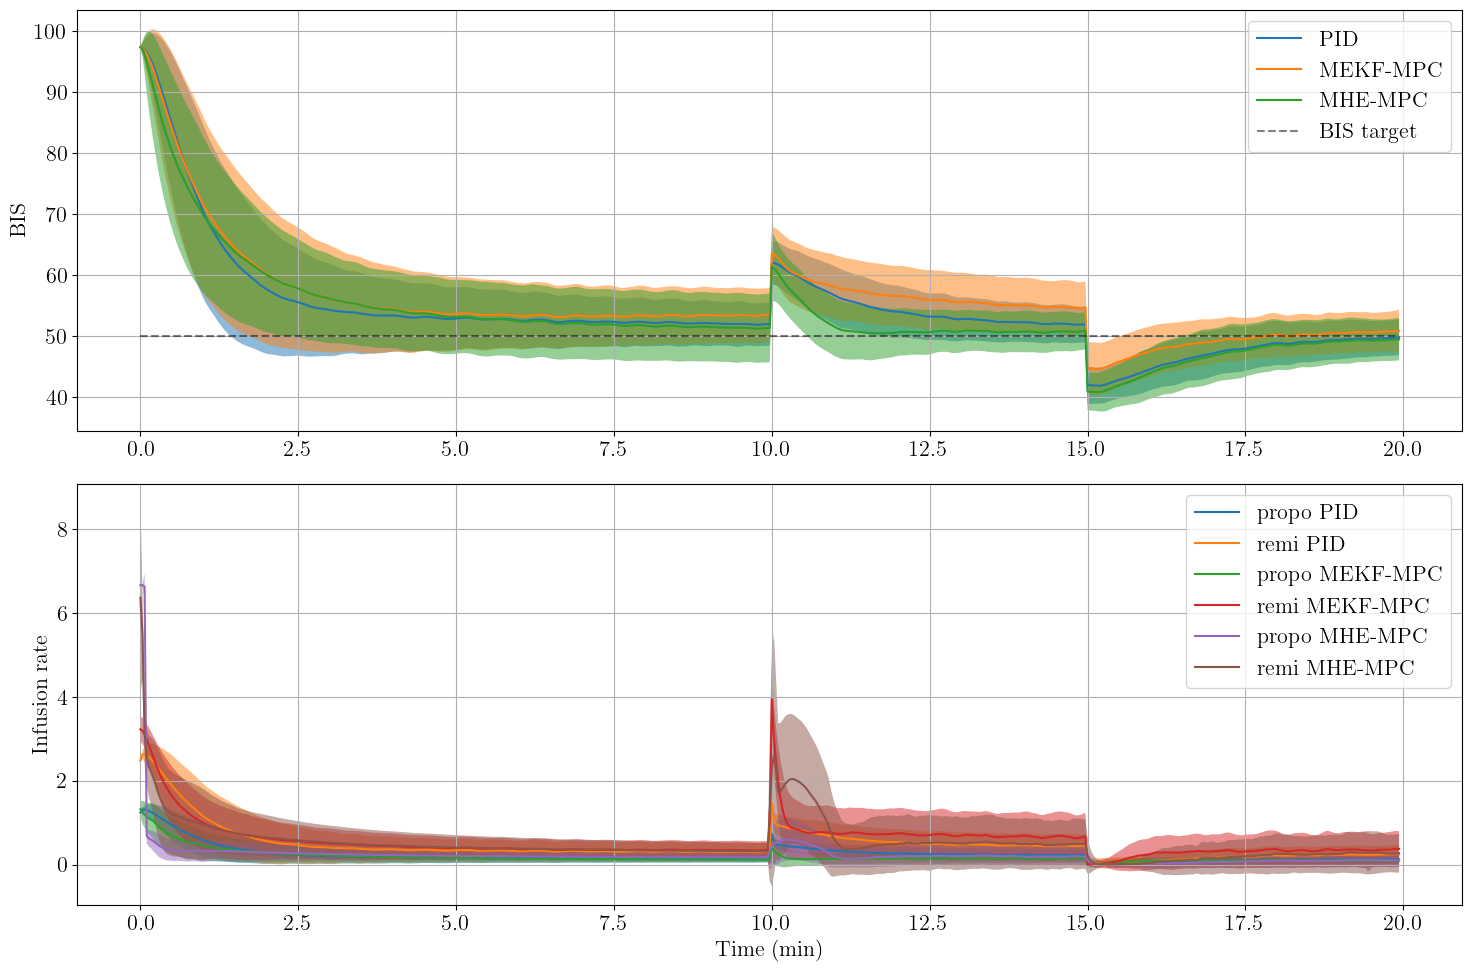

In [21]:
# plot the results
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)

for i, result in enumerate(results):
    mean_bis = result.groupby('Time')['BIS'].mean()
 
    std_bis = result.groupby('Time')['BIS'].std()

    plt.plot(mean_bis.index/60, mean_bis, label=name_plot[i])
    plt.fill_between(mean_bis.index/60, mean_bis - std_bis, mean_bis + std_bis, alpha=0.5)

plt.hlines(50, 0, max(mean_bis.index/60), 'black', '--', label='BIS target', alpha=0.5)
plt.legend(fontsize=16)
plt.ylabel('BIS', fontsize=16)
plt.grid()

plt.subplot(2, 1, 2)
for i, result in enumerate(results):
    mean_propo = result.groupby('Time')['u_propo'].mean()
    std_propo = result.groupby('Time')['u_propo'].std()
    mean_remi = result.groupby('Time')['u_remi'].mean()
    std_remi = result.groupby('Time')['u_remi'].std()

    plt.plot(mean_propo.index/60, mean_propo, label=f'propo {name_plot[i]}')
    plt.fill_between(mean_propo.index/60, mean_propo - std_propo, mean_propo + std_propo, alpha=0.5)
    plt.plot(mean_remi.index/60, mean_remi, label=f'remi {name_plot[i]}')
    plt.fill_between(mean_remi.index/60, mean_remi - std_remi, mean_remi + std_remi, alpha=0.5)

#set legend test size
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('Time (min)', fontsize=16)
plt.ylabel('Infusion rate', fontsize=16)

plt.tight_layout()
plt.savefig(f"outputs/{''.join(study_name_list)}.pdf")

plt.show()

In [22]:
# Compute the metrics
df_metrics = None

MAINTENANCE_TIME = 599
# get weight list

weight_list = results[0].groupby('caseid')['weight'].mean()

for i, result in enumerate(results):
    for caseid, df_case in result.groupby('caseid'):

        Time_induction = df_case.Time[df_case.Time <= MAINTENANCE_TIME].values
        BIS_induction = df_case.BIS[df_case.Time <= MAINTENANCE_TIME].values

        Time_maintenance = df_case.Time[df_case.Time > MAINTENANCE_TIME].values
        BIS_maintenance = df_case.BIS[df_case.Time > MAINTENANCE_TIME].values

        df_line_induction = metrics.new_metrics_induction(Time_induction, BIS_induction)
        df_line_induction = df_line_induction.rename(columns={'IAE': 'IAE_i',
                                                              'Lowest BIS': 'Lowest BIS_i',})
        df_line_maintenance = metrics.new_metrics_maintenance(Time_maintenance, BIS_maintenance)
        df_line_maintenance = df_line_maintenance.rename(columns={'IAE': 'IAE_m',
                                                                  'Lowest BIS': 'Lowest BIS_m',})

        df_line = pd.concat((df_line_induction, df_line_maintenance), axis=1)
        df_line['controller'] = name_plot[i]
        df_line['case_id'] = caseid


        df_line['full_cost_IAE'] = compute_cost(df_case, 'IAE_biased_normal')
        ts = df_case['Time'].values[1] - df_case['Time'].values[0]
        weight = weight_list[caseid]
        df_line['Propo_volume_induction'] = df_case['u_propo'][df_case.Time <= MAINTENANCE_TIME].sum()*ts / weight
        df_line['Propo_volume_maintenance'] = df_case['u_propo'][df_case.Time > MAINTENANCE_TIME].sum()*ts / weight
        df_line['Remi_volume_induction'] = df_case['u_remi'][df_case.Time <= MAINTENANCE_TIME].sum()*ts / weight
        df_line['Remi_volume_maintenance'] = df_case['u_remi'][df_case.Time > MAINTENANCE_TIME].sum()*ts / weight

        if df_metrics is None:
            df_metrics = df_line
        else:
            df_metrics = pd.concat((df_metrics, df_line), axis=0)


In [23]:

# Compute mean_std, min, and max for each column grouped by 'study'
df_stats = df_metrics.groupby('controller').agg(['mean', 'std', 'min', 'max'])

# df_stats.sort_index(axis=1, inplace=True)
round_number = 1
for metric in df_metrics.columns:
    if metric == 'controller':
        continue
    if 'IAE' in metric:
        df_stats[metric, 'mean'] = [str(int(mean)) + ' ± ' + str(int(std)) for mean, std in zip(df_stats[metric, 'mean'].values, df_stats[metric, 'std'].values)]
        df_stats[metric, 'min'] = df_stats[metric, 'min'].astype(int).round(0).astype(str)
        df_stats[metric, 'max'] = df_stats[metric, 'max'].astype(int).round(0).astype(str)
    else:
        df_stats[metric, 'mean'] = [str(round(mean, round_number)) + ' ± ' + str(round(std, round_number)) for mean, std in zip(df_stats[metric, 'mean'].values, df_stats[metric, 'std'].values)]
        df_stats[metric, 'min'] = df_stats[metric, 'min'].astype(float).round(round_number).astype(str)
        df_stats[metric, 'max'] = df_stats[metric, 'max'].astype(float).round(round_number).astype(str)
    df_stats = df_stats.drop(columns=[(metric, 'std')])

# remove specific columns
df_stats.drop(columns=[('full_cost_IAE', 'min'),
                       ('IAE_i', 'min'),
                       ('IAE_m', 'min'),
                       ('Sleep_Time', 'min'),
                       ('Sleep_Time', 'max'),
                       ('Lowest BIS_i', 'max'),
                       ('Settling time', 'min'),
                       ('Settling time', 'max'),
                       ('Low BIS time', 'min'),
                       ('Propo_volume_induction', 'min'),
                       ('Propo_volume_maintenance', 'min'),
                       ('Remi_volume_induction', 'min'),
                       ('Remi_volume_maintenance', 'min'),
                       ('Lowest BIS_m', 'max'),
                       ('Time out of range', 'min'),
                       ('Highest BIS', 'min')], inplace=True)

induction_metrics = ['IAE_i', 'Sleep_Time', 'Settling time', 'Low BIS time', 'Lowest BIS_i', 'Propo_volume_induction', 'Remi_volume_induction']
maintenance_metrics = ['IAE_m', 'Time out of range', 'Lowest BIS_m', 'Highest BIS', 'Propo_volume_maintenance', 'Remi_volume_maintenance']

df_stats_induction = df_stats[induction_metrics]
df_stats_maintenance = df_stats[maintenance_metrics]




print(df_stats_induction.to_markdown())
print('\n')
print(df_stats_maintenance.to_markdown())
print('\n')
print(df_stats['full_cost_IAE'].to_markdown())

# export induction to latex table
styler = df_stats_induction.style
filename = f'./outputs/inducion_{"".join(study_name_list)}.tex'
styler.to_latex(filename, hrules=True, column_format='l|'+'cc|'+'c|'*2+'cc|'*(len(induction_metrics)-3))

# in the latex file replace every '_' by '\_'
# in the latex file replace every '±' by '$\pm$'

with open(filename, 'r') as file:
    filedata = file.read()
    filedata = filedata.replace('_', '\_')
    filedata = filedata.replace('±', '$\pm$')
with open(filename, 'w') as file:
    file.write(filedata)

# export induction to latex table
styler = df_stats_maintenance.style
filename = f'./outputs/maintenance_{"".join(study_name_list)}.tex'
styler.to_latex(filename, hrules=True, column_format='l|'+'cc|'*len(maintenance_metrics))

# in the latex file replace every '_' by '\_'
# in the latex file replace every '±' by '$\pm$'

with open(filename, 'r') as file:
    filedata = file.read()
    filedata = filedata.replace('_', '\_')
    filedata = filedata.replace('±', '$\pm$')
with open(filename, 'w') as file:
    file.write(filedata)


| controller   | ('IAE_i', 'mean')   |   ('IAE_i', 'max') | ('Sleep_Time', 'mean')   | ('Settling time', 'mean')   | ('Low BIS time', 'mean')   |   ('Low BIS time', 'max') | ('Lowest BIS_i', 'mean')   |   ('Lowest BIS_i', 'min') | ('Propo_volume_induction', 'mean')   |   ('Propo_volume_induction', 'max') | ('Remi_volume_induction', 'mean')   |   ('Remi_volume_induction', 'max') |
|:-------------|:--------------------|-------------------:|:-------------------------|:----------------------------|:---------------------------|--------------------------:|:---------------------------|--------------------------:|:-------------------------------------|------------------------------------:|:------------------------------------|-----------------------------------:|
| MEKF-MPC     | 5808 ± 2663         |              20110 | 4.2 ± 3.4                | 4.5 ± 3.4                   | 6.7 ± 29.4                 |                       422 | 46.4 ± 5.5                 |                      23.2 | 1.9

In [24]:
controller_list = ['PID', 'MEKF-MPC', 'MHE-MPC']
print('Percentage of case with BIS under 40')
for controller in controller_list:
    df = df_metrics[df_metrics['controller'] == controller]
    print(f'{controller}: {100*(df["Lowest BIS_i"] < 40).mean():.1f}%')

Percentage of case with BIS under 40
PID: 10.9%
MEKF-MPC: 10.6%
MHE-MPC: 11.8%


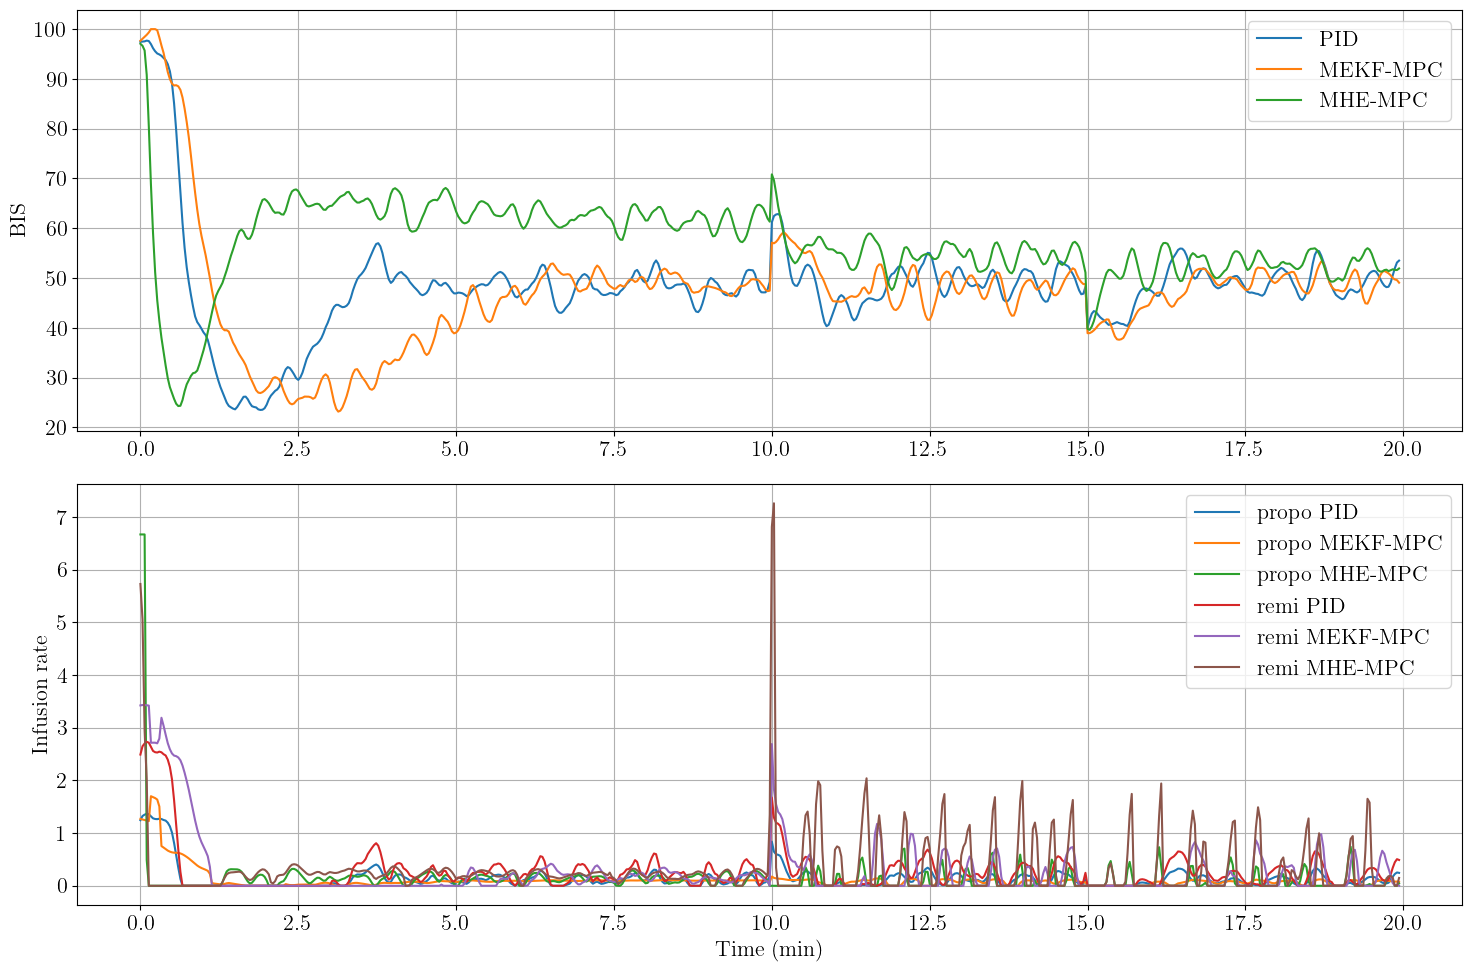

In [25]:
# select PID line
pid_line = df_metrics[df_metrics.controller == name_plot[0]]
mhe_line = df_metrics[df_metrics.controller == name_plot [2]]
mekf_line = df_metrics[df_metrics.controller == name_plot[1]]

# get worst case for each study
pid_worst = pid_line[pid_line['Lowest BIS_i'] == pid_line['Lowest BIS_i'].min()]['case_id']
mhe_worst = mhe_line[mhe_line['Lowest BIS_i'] == mhe_line['Lowest BIS_i'].min()]['case_id']
mekf_worst = mekf_line[mekf_line['Lowest BIS_i'] == mekf_line['Lowest BIS_i'].min()]['case_id']

# get the worst case
for i, result in enumerate(results):
    if 'PID' in study_name_list[i]:
        pid_worst_case = result[result.caseid == pid_worst.values[0]]
    elif 'MHE' in study_name_list[i]:
        mhe_worst_case = result[result.caseid == mhe_worst.values[0]]
    elif 'MEKF' in study_name_list[i]:
        mekf_worst_case = result[result.caseid == mekf_worst.values[0]]
    
# plot the worst case
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(pid_worst_case.Time/60, pid_worst_case.BIS, label='PID')
plt.plot(mekf_worst_case.Time/60, mekf_worst_case.BIS, label='MEKF-MPC')
plt.plot(mhe_worst_case.Time/60, mhe_worst_case.BIS, label='MHE-MPC')
plt.legend(fontsize=16)
plt.ylabel('BIS', fontsize=16)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(pid_worst_case.Time/60, pid_worst_case.u_propo, label='propo PID')
plt.plot(mekf_worst_case.Time/60, mekf_worst_case.u_propo, label='propo MEKF-MPC')
plt.plot(mhe_worst_case.Time/60, mhe_worst_case.u_propo, label='propo MHE-MPC')
plt.plot(pid_worst_case.Time/60, pid_worst_case.u_remi, label='remi PID')
plt.plot(mekf_worst_case.Time/60, mekf_worst_case.u_remi, label='remi MEKF-MPC')
plt.plot(mhe_worst_case.Time/60, mhe_worst_case.u_remi, label='remi MHE-MPC')
plt.legend(fontsize=16)
plt.xlabel('Time (min)', fontsize=16)
plt.ylabel('Infusion rate', fontsize=16)
plt.grid()

plt.tight_layout()
plt.savefig("outputs/worst_case.pdf")
plt.show()

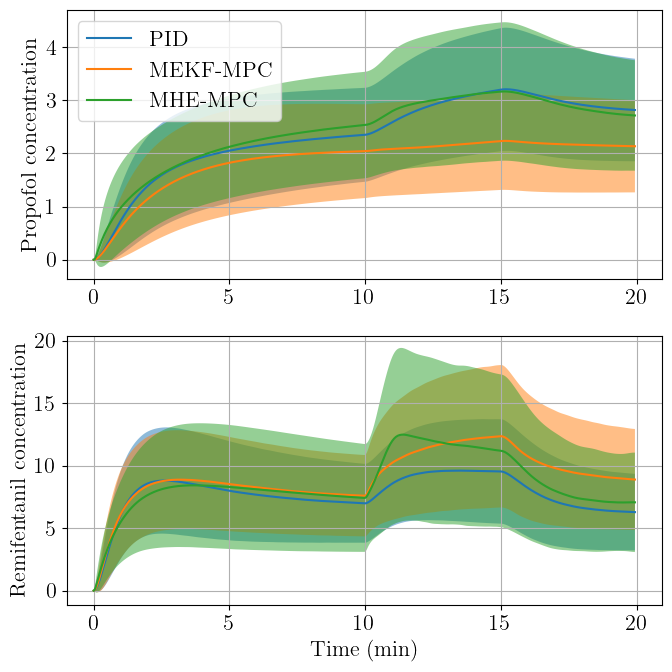

In [26]:
plt.figure(figsize=(7, 7))


for i, result in enumerate(results):
    result['x_propo'] = result['x'].apply(lambda x: x.strip("[]").split()[3]).astype(float)
    result['x_remi'] = result['x'].apply(lambda x: x.strip("[]").split()[7]).astype(float)

    mean_propo_ce = result.groupby('Time')['x_propo'].mean()
    std_propo_ce = result.groupby('Time')['x_propo'].std()

    mean_remi_ce = result.groupby('Time')['x_remi'].mean()
    std_remi_ce = result.groupby('Time')['x_remi'].std()
    plt.subplot(2, 1, 1)
    plt.plot(mean_propo_ce.index/60, mean_propo_ce, label=f'{name_plot[i]}')
    plt.fill_between(mean_propo_ce.index/60, mean_propo_ce - std_propo_ce, mean_propo_ce + std_propo_ce, alpha=0.5)
    plt.subplot(2, 1, 2)
    plt.plot(mean_remi_ce.index/60, mean_remi_ce, label=f'{name_plot[i]}')
    plt.fill_between(mean_remi_ce.index/60, mean_remi_ce - std_remi_ce, mean_remi_ce + std_remi_ce, alpha=0.5)

plt.subplot(2, 1, 1)
plt.legend(fontsize=16)
plt.ylabel('Propofol concentration', fontsize=16)
plt.grid()


plt.subplot(2, 1, 2)
# plt.legend(fontsize=16)
plt.xlabel('Time (min)', fontsize=16)
plt.ylabel('Remifentanil concentration', fontsize=16)
plt.grid()
plt.tight_layout()
plt.savefig("outputs/concentration.pdf")

In [27]:
print('Mean control step time:')
for i, result in enumerate(results):
    print(f"{name_plot[i]}: {result['step_time'].mean():.05f}")

Mean control step time:
PID: 0.00002
MEKF-MPC: 0.13185
MHE-MPC: 0.16564
